In [1]:
%pylab inline
import numpy as np
from scipy.special import erf
from time import time
import datetime
from SparseARD import *

retrain = False
results_file = './saved_results/all_othogonal_tests.npy'

np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


In [2]:
log_sigma_min = -3
log_sigma_max = 0
n_sigmas = 25
n_trials = 50
n_Sigmas = 10*n_sigmas # finer grid for plotting analytical estimates

estimate_sigma = False
maxit=1500

alphas = [1,2,4,8]
lambdas = [0,10,10**2,10**4]
lambdas_scaled = [0,1,5,10]
taus_M = [0,0.01,0.05,0.25]
taus_L = [np.inf, 1, 0.1, 0.01]
taus_MAP = [0,0.2,2,20]
all_params = [alphas,lambdas,lambdas_scaled,taus_M,taus_L,taus_MAP]

# Note m>=n for features to be orthogonal
n = 250
m = 250
s = 25

sigmas = np.logspace(log_sigma_min, log_sigma_max, n_sigmas)
Sigmas = np.logspace(log_sigma_min, log_sigma_max, n_Sigmas)

In [3]:
Added = {}
Missed = {}

for key,params in zip(['VI', 'R', 'Rs', 'M', 'L', 'MAP'], all_params):
    
    Added[key] = [np.zeros((n_trials, n_sigmas)) for _ in range(len(params))]
    Missed[key] = [np.zeros((n_trials, n_sigmas)) for _ in range(len(params))]

Rhos = []
X_nz = []

In [4]:
if retrain:

    start_time = time()

    for i in range(n_trials):

        # Get random orthogonal design matrix
        rho = 1 + 2*np.random.rand(n)
        A = np.random.randn(m,n)
        Theta = np.sqrt(rho)*np.linalg.svd(A)[0][:,:n]
        Rhos.append(rho)

        # Get random sparse xi
        x_nz = np.random.randn(s,1)
        xi = np.zeros((n,1))
        xi[:s] = x_nz
        X_nz.append(x_nz)

        # Get noise instance
        nu0 = np.random.randn(m,1)

        for j in range(n_sigmas):

            if i == 0 and j == 0:
                print('Trial', i+1, 'of', str(n_trials)+'.  sigma', j+1, 'of', n_sigmas)
            else:
                ETA = int((n_trials*n_sigmas-i*n_sigmas-j)*(time()-start_time)/(i*n_sigmas+j))
                print('Trial', i+1, 'of', str(n_trials)+'.  sigma', j+1, 'of', str(n_sigmas)+\
                      '.  ETA:', str(datetime.timedelta(seconds=ETA)))

            sigma = sigmas[j]
            y = Theta.dot(xi) + sigma*nu0

            #
            # ARD-VI
            #
            for k in range(len(alphas)):

                # Solve ARD-VI
                xi_hat = SBL([Theta,y], alpha=alphas[k], sigma2=sigma**2, verbose=False, \
                                     estimate_sigma = estimate_sigma, maxit=maxit)[2]

                # Record sparsity
                total, added, missed = sparsity_err(xi_hat, xi)
                Added['VI'][k][i,j] = added
                Missed['VI'][k][i,j] = missed

            #
            # ARDr without scaling by sigma^-2
            #
            for k in range(len(lambdas)):

                if lambdas[k] == 0: 
                    xi_hat = SBL([Theta,y], sigma2=sigma**2, verbose=False, \
                                 estimate_sigma = estimate_sigma, maxit=maxit)[2]
                else: xi_hat = SBL([Theta,y], lam=lambdas[k]*sigma**2, sigma2=sigma**2, verbose=False, \
                                     estimate_sigma = estimate_sigma, maxit=maxit)[2][1]

                # Record sparsity
                total, added, missed = sparsity_err(xi_hat, xi)
                Added['R'][k][i,j] = added
                Missed['R'][k][i,j] = missed
                
            #
            # ARDr with scaling by sigma^-2
            #
            for k in range(len(lambdas_scaled)):
                
                # Solve with rescaling by sigma^-2
                if lambdas_scaled[k] == 0: 
                    xi_hat = SBL([Theta,y], sigma2=sigma**2, verbose=False, \
                                 estimate_sigma = estimate_sigma, maxit=maxit)[2]
                else: xi_hat = SBL([Theta,y], lam=lambdas_scaled[k], sigma2=sigma**2, verbose=False, \
                                     estimate_sigma = estimate_sigma, maxit=maxit)[2][1]

                # Record sparsity
                total, added, missed = sparsity_err(xi_hat, xi)
                Added['Rs'][k][i,j] = added
                Missed['Rs'][k][i,j] = missed

            #
            # M-STSBL
            #
            for k in range(len(taus_M)):

                xi_hat = M_STSBL(Theta, y, tau=taus_M[k], sigma2=sigma**2, verbose=False, \
                                 estimate_sigma = estimate_sigma, maxit=maxit)[0]

                # Record sparsity
                total, added, missed = sparsity_err(xi_hat, xi)
                Added['M'][k][i,j] = added
                Missed['M'][k][i,j] = missed

            #
            # L-STSBL
            #
            for k in range(len(taus_L)):

                xi_hat= L_STSBL(Theta, y, tau = taus_L[k], sigma2=sigma**2, verbose=False,\
                                estimate_sigma=estimate_sigma, maxit=maxit)[0]

                # Record sparsity
                total, added, missed = sparsity_err(xi_hat, xi)
                Added['L'][k][i,j] = added
                Missed['L'][k][i,j] = missed


            #
            # MAP-STSBL
            #
            for k in range(len(taus_MAP)):

                # Solve MAP-STSBL
                xi_hat = MAP_STSBL(Theta, y, taus_MAP[k], sigma2=sigma**2, maxit=maxit, \
                                   estimate_sigma=estimate_sigma,verbose=False)[0]

                # Record sparsity
                total, added, missed = sparsity_err(xi_hat, xi)
                Added['MAP'][k][i,j] = added
                Missed['MAP'][k][i,j] = missed

    # Save results
    results = {'Added': Added, \
               'Missed': Missed, \
               'Rhos': Rhos, \
               'X_nz' : X_nz}
    np.save(results_file, results)
    
else:
    results = np.load(results_file, allow_pickle=True).item()
    Added = results['Added']    
    Missed = results['Missed']    
    Rhos = results['Rhos']    
    X_nz = results['X_nz']

In [5]:
E_missed = {}
E_added = {}

for key,params in zip(['VI', 'R', 'Rs', 'M', 'L', 'MAP'], all_params):
    E_missed[key] = [np.zeros((n_trials, n_Sigmas)) for _ in range(len(params))]
    E_added[key] = [np.zeros((n_trials, n_Sigmas)) for _ in range(len(params))]

### Results for variance inflation

In [6]:
for k in range(len(alphas)):
    
    alpha = alphas[k]
    E_added['VI'][k] = np.ones((n_trials, n_Sigmas))*(1-erf(np.sqrt(alpha/2)))*(n-s)
        
    for j in range(10*n_sigmas):

        sigma = Sigmas[j]
        
        for i in range(n_trials):

            rho_nz = Rhos[i][:s]
            x_nz = X_nz[i]
            
            width = sigma*np.sqrt(alpha/rho_nz)
            scale = sigma*np.sqrt(2/rho_nz)
            
            E_missed['VI'][k][i,j] = 0.5*np.sum([erf((x_nz[l]+width[l])/scale[l]) - \
                                                 erf((x_nz[l]-width[l])/scale[l]) \
                                                 for l in range(s)])

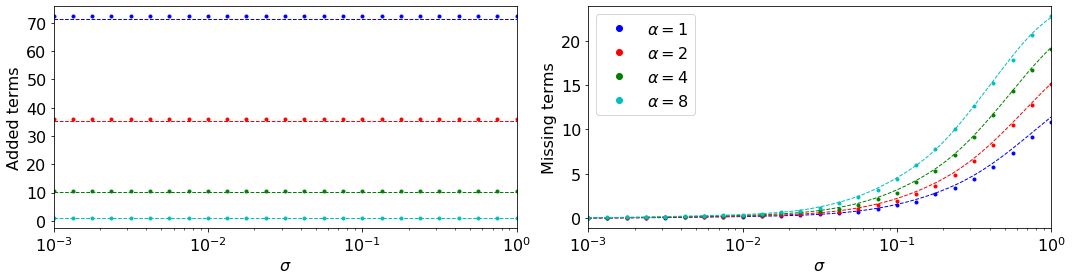

In [7]:
figure(figsize = (15,4))
fontsize = 16

colors = ['b', 'r', 'g', 'c']

####################################################################################################
subplot(1,2,1)

for k in range(len(alphas)):
    plot(sigmas, Added['VI'][k].mean(0), colors[k]+'.', label=r'$\alpha=$'+str(alphas[k]))
    plot(Sigmas, E_added['VI'][k].mean(0), colors[k]+'--', linewidth=1)

xscale('log')
ylabel('Added terms', fontsize=fontsize)
xlabel(r'$\sigma$', fontsize=fontsize)
xlim(sigmas[0],sigmas[-1])
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

####################################################################################################
subplot(1,2,2)

for k in range(len(alphas)):
    plot(sigmas, Missed['VI'][k].mean(0), colors[k]+'.', label=r'$\alpha=$'+str(alphas[k]))
    plot(Sigmas, E_missed['VI'][k].mean(0), colors[k]+'--', linewidth=1)

xscale('log')
ylabel('Missing terms', fontsize=fontsize)
xlabel(r'$\sigma$', fontsize=fontsize)
xlim(sigmas[0],sigmas[-1])
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

legend(fontsize = fontsize, markerscale = 2)
tight_layout()

### Results for ARDr without rescaling

In [8]:
for k in range(len(lambdas)):
    for j in range(10*n_sigmas):

        sigma = Sigmas[j]        
        lam = lambdas[k]
        
        for i in range(n_trials):

            rho = Rhos[i]
            x_nz = X_nz[i]
                        
            # Expected error without rescaling
            E_added['R'][k][i,j] = np.sum([1-erf(np.sqrt((1+lam*sigma**2/rho[l])/2)) \
                                          for l in range(s,m)])
            
            width = np.sqrt(sigma**2/rho+lam*sigma**4/rho**2)
            scale = sigma*np.sqrt(2/rho[:s])
            
            E_missed['R'][k][i,j] = 0.5*np.sum([erf((x_nz[l]+width[l])/scale[l]) - \
                                                erf((x_nz[l]-width[l])/scale[l]) \
                                                for l in range(s)])

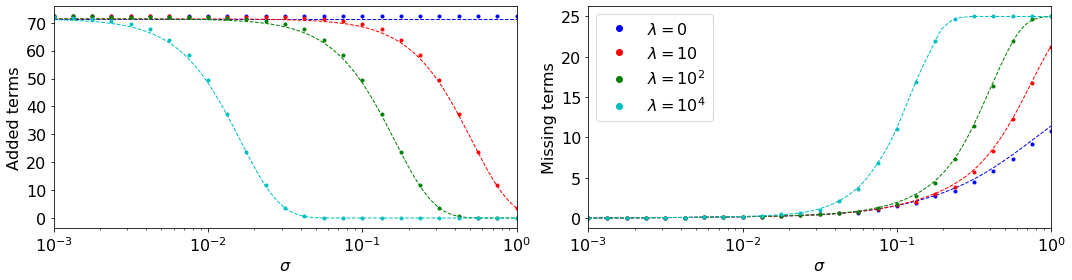

In [9]:
figure(figsize = (15,4))
fontsize = 16

colors = ['b', 'r', 'g', 'c']
lambda_labels = [r'$\lambda=0$',r'$\lambda=10$',r'$\lambda=10^2$',r'$\lambda=10^4$']

####################################################################################################
subplot(1,2,1)

for k in range(len(lambdas)):
    plot(sigmas, Added['R'][k].mean(0), colors[k]+'.', label=lambda_labels[k])
    plot(Sigmas, E_added['R'][k].mean(0), colors[k]+'--', linewidth=1)

xscale('log')
ylabel('Added terms', fontsize=fontsize)
xlabel(r'$\sigma$', fontsize=fontsize)
xlim(sigmas[0],sigmas[-1])
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

####################################################################################################
subplot(1,2,2)

for k in range(len(lambdas)):
    plot(sigmas, Missed['R'][k].mean(0), colors[k]+'.', label=lambda_labels[k])
    plot(Sigmas, E_missed['R'][k].mean(0), colors[k]+'--', linewidth=1)

xscale('log')
ylabel('Missing terms', fontsize=fontsize)
xlabel(r'$\sigma$', fontsize=fontsize)
xlim(sigmas[0],sigmas[-1])
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

legend(fontsize = fontsize, markerscale = 2)
tight_layout()

### Results for ARDr with rescaling

In [10]:
for k in range(len(lambdas)):
    for j in range(10*n_sigmas):

        sigma = Sigmas[j]        
        lam_s = lambdas_scaled[k]/sigma**2
        
        for i in range(n_trials):

            rho = Rhos[i]
            x_nz = X_nz[i]
            
            # Expected error with rescaling
            E_added['Rs'][k][i,j] = np.sum([1-erf(np.sqrt((1+lam_s*sigma**2/rho[l])/2)) \
                                          for l in range(s,m)])
            
            width = np.sqrt(sigma**2/rho+lam_s*sigma**4/rho**2)
            scale = sigma*np.sqrt(2/rho[:s])
            
            E_missed['Rs'][k][i,j] = 0.5*np.sum([erf((x_nz[l]+width[l])/scale[l]) - \
                                                erf((x_nz[l]-width[l])/scale[l]) \
                                                for l in range(s)])

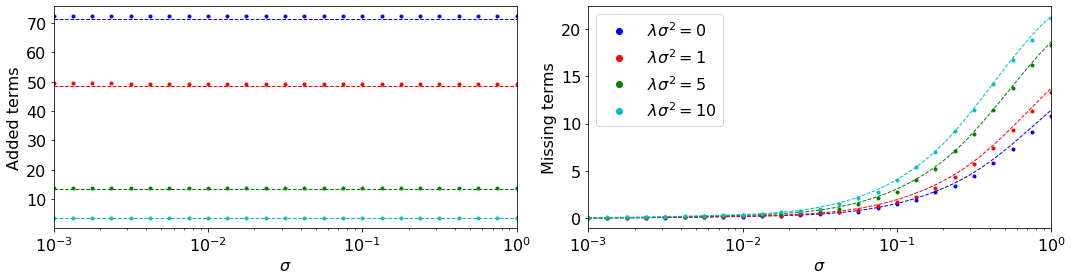

In [11]:
figure(figsize = (15,4))
fontsize = 16

colors = ['b', 'r', 'g', 'c']

####################################################################################################
subplot(1,2,1)

for k in range(len(lambdas_scaled)):
    plot(sigmas, Added['Rs'][k].mean(0), colors[k]+'.', label=r'$\lambda=$'+str(lambdas_scaled[k]))
    plot(Sigmas, E_added['Rs'][k].mean(0), colors[k]+'--', linewidth=1)

xscale('log')
ylabel('Added terms', fontsize=fontsize)
xlabel(r'$\sigma$', fontsize=fontsize)
xlim(sigmas[0],sigmas[-1])
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

####################################################################################################
subplot(1,2,2)

for k in range(len(lambdas_scaled)):
    plot(sigmas, Missed['Rs'][k].mean(0), colors[k]+'.', label=r'$\lambda\sigma^2=$'+str(lambdas_scaled[k]))
    plot(Sigmas, E_missed['Rs'][k].mean(0), colors[k]+'--', linewidth=1)

xscale('log')
ylabel('Missing terms', fontsize=fontsize)
xlabel(r'$\sigma$', fontsize=fontsize)
xlim(sigmas[0],sigmas[-1])
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

legend(fontsize = fontsize, markerscale = 2)
tight_layout()

### Results for M-STSBL

In [12]:
def phi(t, sigma, rho): 
    if t==0: return sigma/np.sqrt(rho)
    else: return (t + np.sqrt(1+4*sigma**2/(rho*t**2))*t)/2
    
for k in range(len(taus_M)):
    
    tau = taus_M[k]
    
    for j in range(10*n_sigmas):

        sigma = Sigmas[j]
        
        for i in range(n_trials):

            rho = Rhos[i]
            x_nz = X_nz[i]
            
            width = phi(tau,sigma,rho)
            scale = sigma*np.sqrt(2/rho)
                        
            E_added['M'][k][i,j] = np.sum([1-erf(width[l]/scale[l]) \
                                          for l in range(s,m)])
            
            E_missed['M'][k][i,j] = 0.5*np.sum([erf((x_nz[l]+width[l])/scale[l]) - \
                                                erf((x_nz[l]-width[l])/scale[l]) \
                                                for l in range(s)])

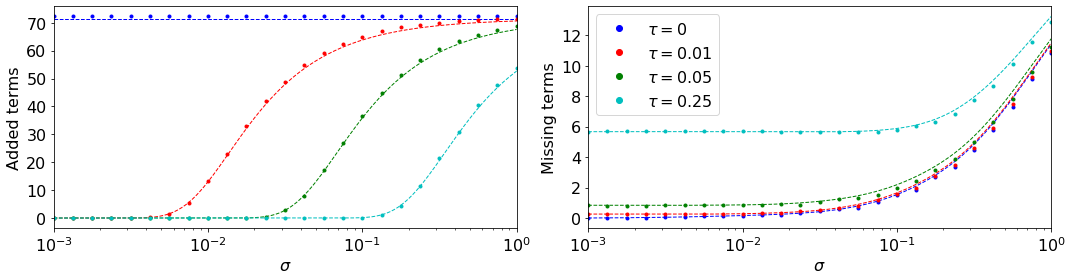

In [13]:
figure(figsize = (15,4))
fontsize = 16

colors = ['b', 'r', 'g', 'c']

####################################################################################################
subplot(1,2,1)

for k in range(len(taus_M)):
    plot(sigmas, Added['M'][k].mean(0), colors[k]+'.', label=r'$\tau=$'+str(taus_M[k]))
    plot(Sigmas, E_added['M'][k].mean(0), colors[k]+'--', linewidth=1)

xscale('log')
ylabel('Added terms', fontsize=fontsize)
xlabel(r'$\sigma$', fontsize=fontsize)
xlim(sigmas[0],sigmas[-1])
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

####################################################################################################
subplot(1,2,2)

for k in range(len(taus_M)):
    plot(sigmas, Missed['M'][k].mean(0), colors[k]+'.', label=r'$\tau=$'+str(taus_M[k]))
    plot(Sigmas, E_missed['M'][k].mean(0), colors[k]+'--', linewidth=1)

xscale('log')
ylabel('Missing terms', fontsize=fontsize)
xlabel(r'$\sigma$', fontsize=fontsize)
xlim(sigmas[0],sigmas[-1])
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

legend(fontsize = fontsize, markerscale = 2)
tight_layout()

### Results for L-STSBL

In [14]:
def T_L(x, sigma, rho):
    sigma2_xi = (rho/sigma**2+rho*(np.sqrt(1 + 4*sigma**2/(rho*x**2))-1)/(2*sigma**2))**-1
    return (np.log(2*np.pi*sigma2_xi) + x**2/sigma2_xi)/2
    
def T_L_inv(tau, sigma, rho, tol = 1e-5):
    
    upper_bound = 1
    for j in range(100):
        if T_L(upper_bound, sigma, rho) < tau:
            upper_bound = upper_bound*2
        else:
            break
        
    n_iter = int(np.log2(upper_bound / tol))+1
    x = upper_bound / 2
    dx = upper_bound / 4
    
    for j in range(n_iter):
        if T_L(x, sigma, rho) < tau: x = x + dx*0.5**j
        elif T_L(x, sigma, rho) > tau: x = x - dx*0.5**j
        else: 
            return x
    return x
    
for k in range(len(taus_L)):
    
    tau = taus_L[k]
    log_inv_tau = -np.log(tau)
    
    for j in range(10*n_sigmas):

        sigma = Sigmas[j]
        
        for i in range(n_trials):

            rho = Rhos[i]
            x_nz = X_nz[i]
            
            width = np.array([phi(T_L_inv(log_inv_tau, sigma, rho[l]),sigma, rho[l]) 
                             for l in range(n)])
            scale = sigma*np.sqrt(2/rho)
                        
            E_added['L'][k][i,j] = np.sum([1-erf(width[l]/scale[l]) \
                                          for l in range(s,m)])
            
            E_missed['L'][k][i,j] = 0.5*np.sum([erf((x_nz[l]+width[l])/scale[l]) - \
                                                erf((x_nz[l]-width[l])/scale[l]) \
                                                for l in range(s)])

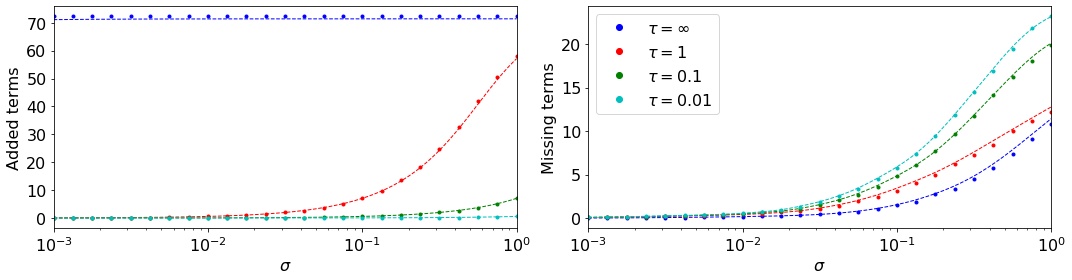

In [15]:
figure(figsize = (15,4))
fontsize = 16

colors = ['b', 'r', 'g', 'c']
tau_labels = [r'$\tau=\infty$',r'$\tau=1$',r'$\tau=0.1$',r'$\tau=0.01$']

####################################################################################################
subplot(1,2,1)

for k in range(len(taus_L)):
    plot(sigmas, Added['L'][k].mean(0), colors[k]+'.', label=tau_labels[k])
    plot(Sigmas, E_added['L'][k].mean(0), colors[k]+'--', linewidth=1)

xscale('log')
ylabel('Added terms', fontsize=fontsize)
xlabel(r'$\sigma$', fontsize=fontsize)
xlim(sigmas[0],sigmas[-1])
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

####################################################################################################
subplot(1,2,2)

for k in range(len(taus_L)):
    plot(sigmas, Missed['L'][k].mean(0), colors[k]+'.', label=tau_labels[k])
    plot(Sigmas, E_missed['L'][k].mean(0), colors[k]+'--', linewidth=1)

xscale('log')
ylabel('Missing terms', fontsize=fontsize)
xlabel(r'$\sigma$', fontsize=fontsize)
xlim(sigmas[0],sigmas[-1])
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

legend(fontsize = fontsize, markerscale = 2)
tight_layout()

### Results for MAP-STSBL

In [16]:
for k in range(len(taus_MAP)):
    
    tau = taus_MAP[k]
    
    for j in range(10*n_sigmas):

        sigma = Sigmas[j]
        
        for i in range(n_trials):

            rho = Rhos[i]
            x_nz = X_nz[i]
            
            width = sigma*np.sqrt((2*tau+1)/rho)
            scale = sigma*np.sqrt(2/rho)
                        
            E_added['MAP'][k][i,j] = np.sum([1-erf(width[l]/scale[l]) \
                                          for l in range(s,m)])
            
            E_missed['MAP'][k][i,j] = 0.5*np.sum([erf((x_nz[l]+width[l])/scale[l]) - \
                                                erf((x_nz[l]-width[l])/scale[l]) \
                                                for l in range(s)])

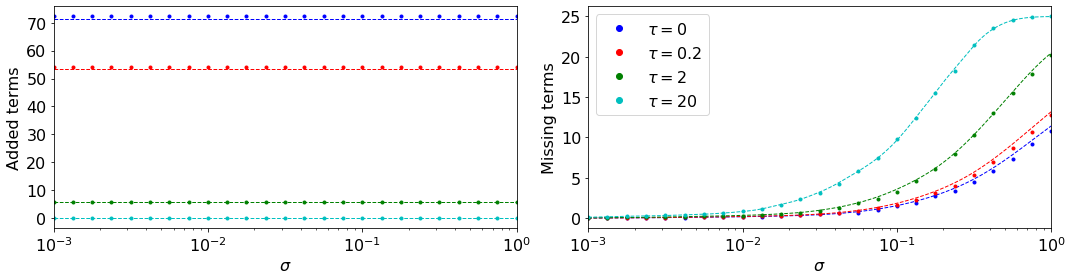

In [17]:
figure(figsize = (15,4))
fontsize = 16

colors = ['b', 'r', 'g', 'c']

####################################################################################################
subplot(1,2,1)

for k in range(len(taus_MAP)):
    plot(sigmas, Added['MAP'][k].mean(0), colors[k]+'.', label=r'$\tau=$'+str(taus_MAP[k]))
    plot(Sigmas, E_added['MAP'][k].mean(0), colors[k]+'--', linewidth=1)

xscale('log')
ylabel('Added terms', fontsize=fontsize)
xlabel(r'$\sigma$', fontsize=fontsize)
xlim(sigmas[0],sigmas[-1])
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

####################################################################################################
subplot(1,2,2)

for k in range(len(taus_MAP)):
    plot(sigmas, Missed['MAP'][k].mean(0), colors[k]+'.', label=r'$\tau=$'+str(taus_MAP[k]))
    plot(Sigmas, E_missed['MAP'][k].mean(0), colors[k]+'--', linewidth=1)

xscale('log')
ylabel('Missing terms', fontsize=fontsize)
xlabel(r'$\sigma$', fontsize=fontsize)
xlim(sigmas[0],sigmas[-1])
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

legend(fontsize = fontsize, markerscale = 2)
tight_layout()